# Simulation

## Data and Pipeline Explanation

This notebook documents steps taken to run all simulations.

**Goal**: To compare the power of rare variant aggregate association tests using exome sequencing and imputed dataset

**Data**:
- Exome sequencing: `ES`
- Imputed dataset: `HRC`, `TOPMed`
- Merged dataset: `HRC_TOPMed`, `ES_HRC_TOPMed`
 
**Data Filtering Parameters**:
- MAF： <0.01, <0.005, <0.001
- $R^2$: (imputed dataset only) > 0.3 or 0.8
- CADD_c-score: $\geq 20$ for missense variants

**Simulation Process**:

1. Generate effect size for the variants within a gene
    - no variant causal -> null
    - all variants causal
    - 50% variants causal
    - 75% variants causal
    
2. Generate phenotype:
$$logit \; p(y_i = 1) = \alpha + \beta G + \epsilon$$
    - $\alpha$ = 0.1, 0.2
    - $\beta$ = log(1.2), log(1.5), log(1.8)
    - $G$ = genetic data
    - $\epsilon$ ~ N(0,1)

3. Sample with replacement for case-control: 40k cases v.s. 60k controls

4. Running BRV

5. Calculate power: proportion of gene reaching exome-wide significant level ($p < 2.5 \times 10^{−6}$)



## Create per gene file

### Exome

In [4]:
library(dplyr)
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/exome")

for(i in c(1,2)){
    for(cadd in c("", "_cadd")){

        snplist_annotated_fname <- sprintf("ukb23156_c%i.merged.filtered.hg38.hg38_multianno_formatted_sel_col_maf001_LOF_missense%s.csv.gz", i, cadd)
        snplist_annotated <- data.table::fread(snplist_annotated_fname)

        gene_lst <- snplist_annotated %>% pull(Gene.refGene) %>% unique()
        print(length(gene_lst))

        fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d%s_exome.sh", i, cadd)
        if(file.exists(fname)) unlink(fname)

        for(g in gene_lst){
            df <- snplist_annotated %>% filter(Gene.refGene == g) %>% select(ID_hg38)

            out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/exome%s/chr%d_%s", cadd, i, g)
            write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)

            command <- sprintf("plink --bfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/exome/ukb23156_c%d_maf001_LOF_missense%s_extracted \\
                                    --extract %s \\
                                    --make-bed \\
                                    --out %s;", 
                               i, cadd, out_fname, out_fname)
            write(command, fname, append=TRUE) 
        }
    }
}

[1] 1953
[1] 1950
[1] 1193
[1] 1192


### HRC

In [7]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc")

for(i in c(1,2)){
    for(rsq in c(3, 8)){
        for(cadd in c("", "_cadd")){
            snplist_annotated_fname <- sprintf("hrc_chr%i_rsq0%i_hg19_hg38_maf001_LOF_missense%s_annot.csv.gz", i, rsq, cadd)
            snplist_annotated <- data.table::fread(snplist_annotated_fname)

            gene_lst <- snplist_annotated %>% pull(Gene.refGene) %>% unique()
            print(length(gene_lst))

            fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d%s_rsq0%i_hrc.sh", i, cadd, rsq)

            if(file.exists(fname)) unlink(fname)
            for(g in gene_lst){
                df <- snplist_annotated %>% filter(Gene.refGene == g) %>% select(ID_hg19)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/hrc%s_rsq0%i/chr%d_%s", cadd, rsq, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)

                command <- sprintf("plink2 --bpfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc/hrc_chr%i_rsq0%i_maf001_LOF_missense%s_extracted \\
                                    --extract %s --export A-transpose --make-bpgen --out %s;", 
                                   i, rsq, cadd, out_fname, out_fname)
                write(command, fname, append=TRUE)
            }
        }
    }
}

[1] 1799
[1] 1626
[1] 1381
[1] 1137
[1] 1123
[1] 1030
[1] 890
[1] 759


### TOPMed

In [10]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/topmed")
for(i in c(1,2)){
    for(rsq in c(3, 8)){
        for(cadd in c("", "_cadd")){
            snplist_annotated_fname <- sprintf("topmed_chr%i_rsq0%i_hg19_hg38_maf001_LOF_missense%s_annot.csv.gz", i, rsq, cadd)
            snplist_annotated <- data.table::fread(snplist_annotated_fname)

            gene_lst <- snplist_annotated %>% pull(Gene.refGene) %>% unique()
            print(length(gene_lst))

            fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d%s_rsq0%i_topmed.sh", i, cadd, rsq)

            if(file.exists(fname)) unlink(fname)
            for(g in gene_lst){
                df <- snplist_annotated %>% filter(Gene.refGene == g) %>% select(ID_hg38)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/topmed%s_rsq0%i/chr%d_%s", cadd, rsq, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)

                command <- sprintf("plink2 --bpfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/topmed/topmed_chr%i_rsq0%i_maf001_LOF_missense%s_extracted \\
                                    --extract %s --export A-transpose --make-bpgen --out %s;", 
                                   i, rsq, cadd, out_fname, out_fname)
                write(command, fname, append=TRUE)
            }
        }
    }
}

[1] 1979
[1] 1971
[1] 1906
[1] 1846
[1] 1207
[1] 1199
[1] 1190
[1] 1167


### ES_HRC_TOPMed

In [12]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed_exome")
annot <- data.table::fread("hrc_topmed_exome_168206ids_rsq03_maf001_annot.csv.gz")
length(unique(annot$Gene.refGene))

[1] 3193

In [13]:
for i in list(range(1, 3194, 50)):
    for j in list(("1")):
        for k in list((3, 8)):
            script='''#!/bin/sh
#$ -l h_rt=24:00:00
#$ -l h_vmem=50G
#$ -N hrc_topmed_exome_maf00%s_rsq0%i_batch%i
#$ -o ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00%s_rsq0%i_batch%i_$JOB_ID.out
#$ -e ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00%s_rsq0%i_batch%i_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
module load R/4.2.2.10
export PATH=$HOME/miniconda3/bin:$PATH
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/mnt/mfs/cluster/R-Deb10_Libs

cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts
Rscript hrc_topmed_exome.R %i %i %s %i

'''%(j, k, int((i+49)/50), j, k, int((i+49)/50), j, k, int((i+49)/50), i, int(i+49), j, k)
            f=open("/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00"+j+"_rsq0"+str(k)+"_batch"+str(int((i+49)/50))+".sh", 'w')
            f.write(script)
            f.close()

In [18]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed_exome")
annot <- data.table::fread("hrc_topmed_exome_168206ids_rsq03_maf001_cadd_annot.csv.gz")
length(unique(annot$Gene.refGene))

[1] 3182

In [19]:
for i in list(range(1, 3183, 50)):
    for j in list(("1")):
        for k in list((3, 8)):
            script='''#!/bin/sh
#$ -l h_rt=24:00:00
#$ -l h_vmem=50G
#$ -N hrc_topmed_exome_maf00%s_rsq0%i_cadd_batch%i
#$ -o ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00%s_rsq0%i_cadd_batch%i_$JOB_ID.out
#$ -e ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00%s_rsq0%i_cadd_batch%i_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
module load R/4.2.2.10
export PATH=$HOME/miniconda3/bin:$PATH
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/mnt/mfs/cluster/R-Deb10_Libs

cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts
Rscript hrc_topmed_exome_cadd.R %i %i %s %i

'''%(j, k, int((i+49)/50), j, k, int((i+49)/50), j, k, int((i+49)/50), i, int(i+49), j, k)
            f=open("/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_exome_maf00"+j+"_rsq0"+str(k)+"_cadd_batch"+str(int((i+49)/50))+".sh", 'w')
            f.write(script)
            f.close()

### HRC_TOPMed

In [14]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed")
annot <- data.table::fread("hrc_topmed_168206ids_rsq03_maf001_annot.csv.gz")
length(unique(annot$Gene.refGene))

[1] 3187

In [15]:
for i in list(range(1, 3188, 50)):
    for j in list(("1")):
        for k in list((3, 8)):
            script='''#!/bin/sh
#$ -l h_rt=24:00:00
#$ -l h_vmem=50G
#$ -N hrc_topmed_exome_maf00%s_rsq0%i_batch%i
#$ -o ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00%s_rsq0%i_batch%i_$JOB_ID.out
#$ -e ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00%s_rsq0%i_batch%i_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
module load R/4.2.2.10
export PATH=$HOME/miniconda3/bin:$PATH
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/mnt/mfs/cluster/R-Deb10_Libs

cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts
Rscript hrc_topmed.R %i %i %s %i

'''%(j, k, int((i+49)/50), j, k, int((i+49)/50), j, k, int((i+49)/50), i, int(i+49), j, k)
            f=open("/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00"+j+"_rsq0"+str(k)+"_batch"+str(int((i+49)/50))+".sh", 'w')
            f.write(script)
            f.close()

In [16]:
## CADD filtering

setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed")
annot <- data.table::fread("hrc_topmed_168206ids_rsq03_maf001_cadd_annot.csv.gz")
length(unique(annot$Gene.refGene))

[1] 3172

In [17]:
for i in list(range(1, 3173, 50)):
    for j in list(("1")):
        for k in list((3, 8)):
            script='''#!/bin/sh
#$ -l h_rt=24:00:00
#$ -l h_vmem=50G
#$ -N hrc_topmed_exome_maf00%s_rsq0%i_cadd_batch%i
#$ -o ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00%s_rsq0%i_cadd_batch%i_$JOB_ID.out
#$ -e ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00%s_rsq0%i_cadd_batch%i_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
module load R/4.2.2.10
export PATH=$HOME/miniconda3/bin:$PATH
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/mnt/mfs/cluster/R-Deb10_Libs

cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts
Rscript hrc_topmed_cadd.R %i %i %s %i

'''%(j, k, int((i+49)/50), j, k, int((i+49)/50), j, k, int((i+49)/50), i, int(i+49), j, k)
            f=open("/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_maf00"+j+"_rsq0"+str(k)+"_cadd_batch"+str(int((i+49)/50))+".sh", 'w')
            f.write(script)
            f.close()

## Running simulation

The simulation pipeline is written in [DSC](https://stephenslab.github.io/dsc-wiki/overview.html), all of the code can be found in `./dsc_pipeline/`

Please modify the `*.dsc` file for input and output directories.

In [ ]:
cd ~/workflow/dsc_pipeline/

dsc bin_pheno_168206id_brv_rsq03.dsc -s lenient -host bin_pheno_168206id_brv.yml
dsc bin_pheno_168206id_brv_rsq08.dsc -s lenient -host bin_pheno_168206id_brv.yml

# Summarize simulation result

There are two ways of summarizing the result. 

During the simulation, results for each gene are written to `.csv` files to an output directory. So we could read all the `.csv` files in that directory, comebine and analyze. Or the other way would be to query result in R from the result database created by DSC (using `dscrutils` package). 

Here, we present code for both ways. But since results have already been compiled, analysis steps will be directly reading compiled csv files

In [27]:
## Combine result csv files

result_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline/bin_pheno_168206id_brv_rsq03/result_csv"

result_df <- data.frame(matrix(nrow = 0, ncol = 5))
colnames(result_df) <- c("zstat", "pval", "maf", "gene", "sample")

flst <- list.files(result_dir, full.names = TRUE)
for(f in flst){
    df <- data.table::fread(f)
    if(ncol(df) != 5) next
    
    result_df <- rbind(result_df, df)
}

In [ ]:
## Query using R package
library(dscrutils)

dsc_dir <- "./bin_pheno_168206id_brv"
result <- dscquery(dsc_dir, )

## Reading results

In [30]:
library(dplyr)
library(data.table)

setwd("~/project/git/imputation_brv/workflow/results")

rsq03_maf0001_result <- fread("rsq03_maf0001_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.001")
rsq03_maf0005_result <- fread("rsq03_maf0005_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.005")
rsq03_maf001_result <- fread("rsq03_maf001_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.01")

rsq03_all_result <- rbind(rsq03_maf0001_result, rsq03_maf0005_result, rsq03_maf001_result) %>% 
    mutate(Dataset = case_when(
        data == 'exome' ~ "ES",
        data == 'exome_cadd' ~ 'ES¹',
        data == 'hrc' ~ 'HRC',
        data == 'hrc_cadd' ~ 'HRC¹',
        data == 'topmed' ~ 'TOPMed',
        data == 'topmed_cadd' ~ 'TOPMed¹',
        data == 'hrc_topmed' ~ 'HRC + TOPMed',
        data == 'hrc_topmed_cadd' ~ 'HRC + TOPMed¹',
        data == 'hrc_topmed_exome' ~ 'HRC + TOPMed + ES',
        data == 'hrc_topmed_exome_cadd' ~ 'HRC + TOPMed + ES¹',
        .default = data))

rsq08_maf0001_result <- fread("rsq08_maf0001_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.001")
rsq08_maf0005_result <- fread("rsq08_maf0005_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.005")
rsq08_maf001_result <- fread("rsq08_maf001_result_all.csv") %>% mutate(power = as.numeric(power), maf = "MAF < 0.01")

rsq08_all_result <- rbind(rsq08_maf0001_result, rsq08_maf0005_result, rsq08_maf001_result) %>% 
    mutate(Dataset = case_when(
        data == 'exome' ~ "ES",
        data == 'exome_cadd' ~ 'ES¹',
        data == 'hrc' ~ 'HRC',
        data == 'hrc_cadd' ~ 'HRC¹',
        data == 'topmed' ~ 'TOPMed',
        data == 'topmed_cadd' ~ 'TOPMed¹',
        data == 'hrc_topmed' ~ 'HRC + TOPMed',
        data == 'hrc_topmed_cadd' ~ 'HRC + TOPMed¹',
        data == 'hrc_topmed_exome' ~ 'HRC + TOPMed + ES',
        data == 'hrc_topmed_exome_cadd' ~ 'HRC + TOPMed + ES¹',
        .default = data))


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




## Line Plots

In [32]:
library(ggplot2)
library(qqman)
library(tidyverse)
library(gridExtra)

text_size = 12



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()   masks dplyr::first()
✖ lubridate::hour()     masks data.table::hour()
✖ lubridate::isoweek()  masks data.table::isoweek()
✖ dplyr::lag()          masks stats::lag()
✖ data.table::last()    masks dplyr::last()
✖ lubridate::mday()     masks data.table::mday()
✖ lubridate::minute()   masks data.table::minu

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


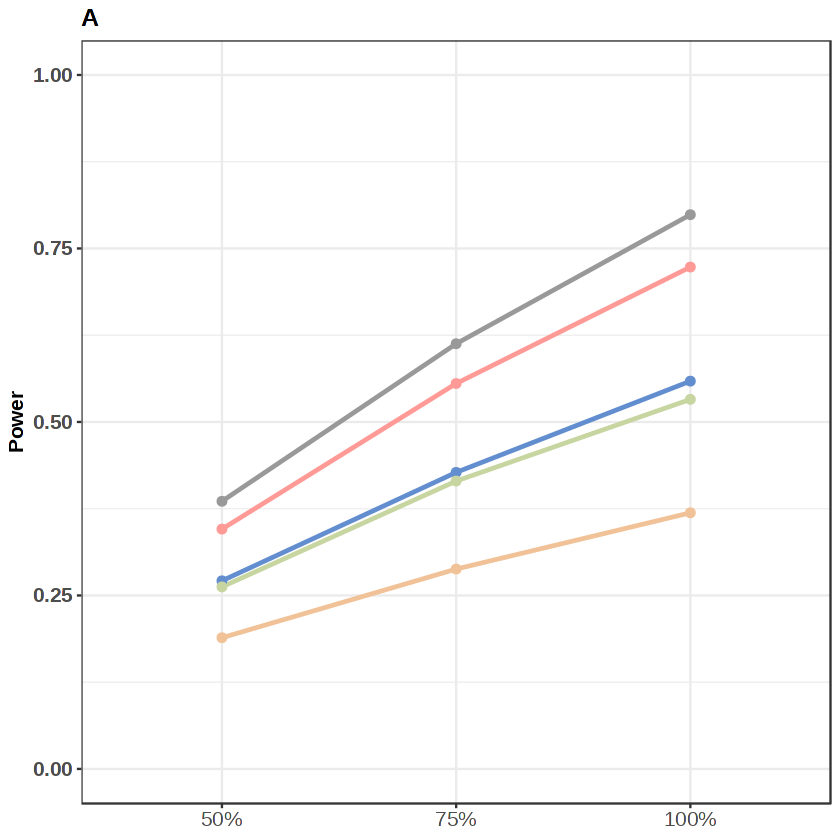

In [33]:
rsq03_maf001_prev01 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.01",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "A") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq03_maf001_prev01

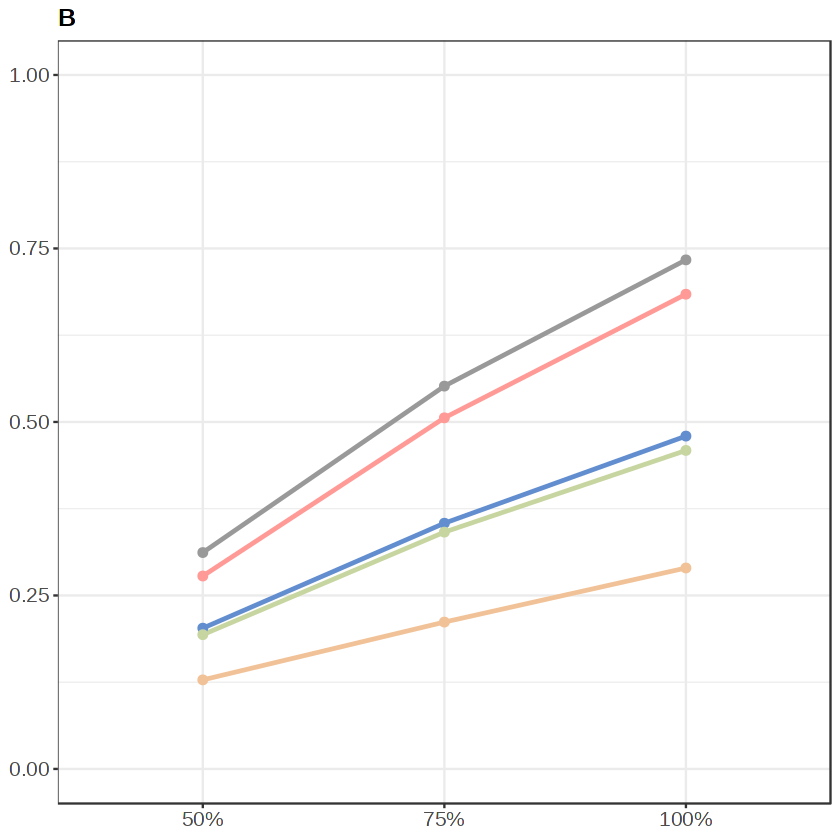

In [34]:
rsq03_maf0005_prev01 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.005",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "B") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x =element_blank(),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq03_maf0005_prev01

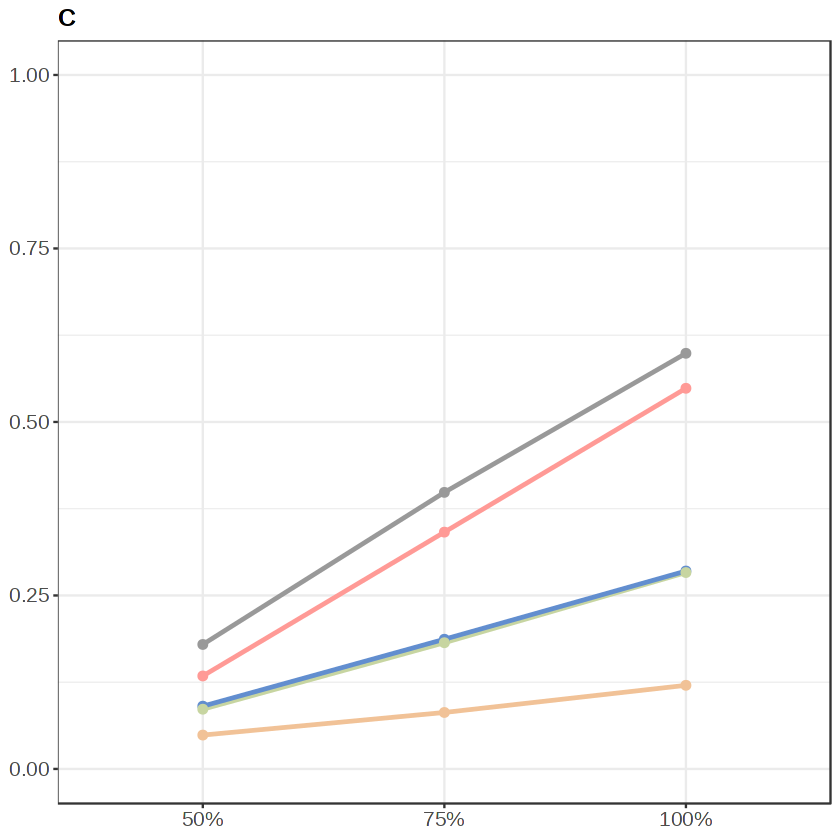

In [35]:
rsq03_maf0001_prev01 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.001",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "C") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x = element_blank(),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq03_maf0001_prev01

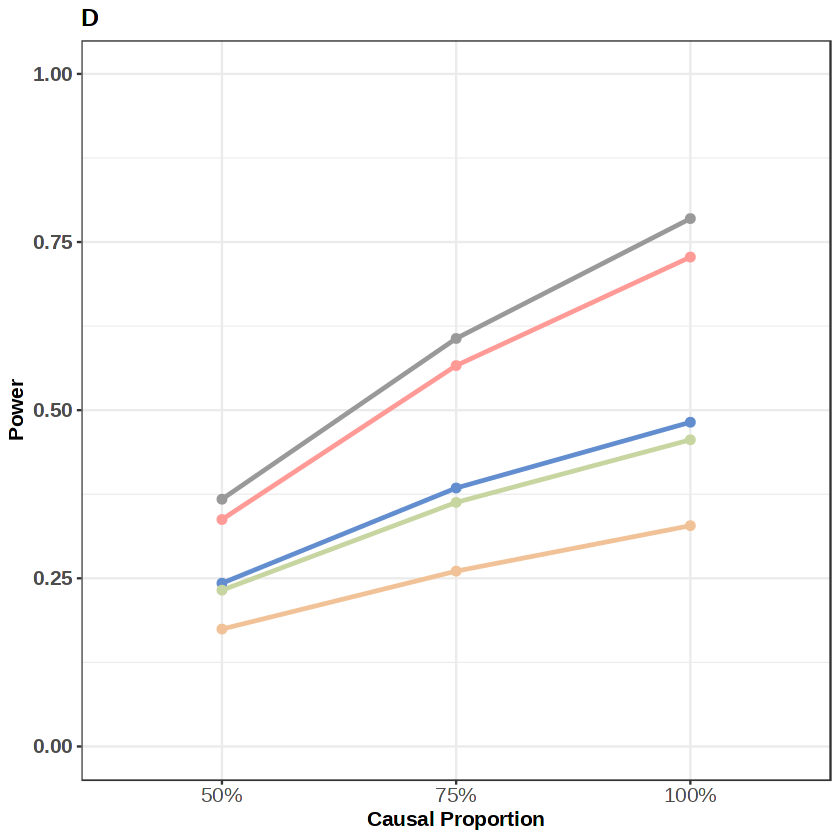

In [36]:
rsq08_maf001_prev01 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.01",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "D") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq08_maf001_prev01

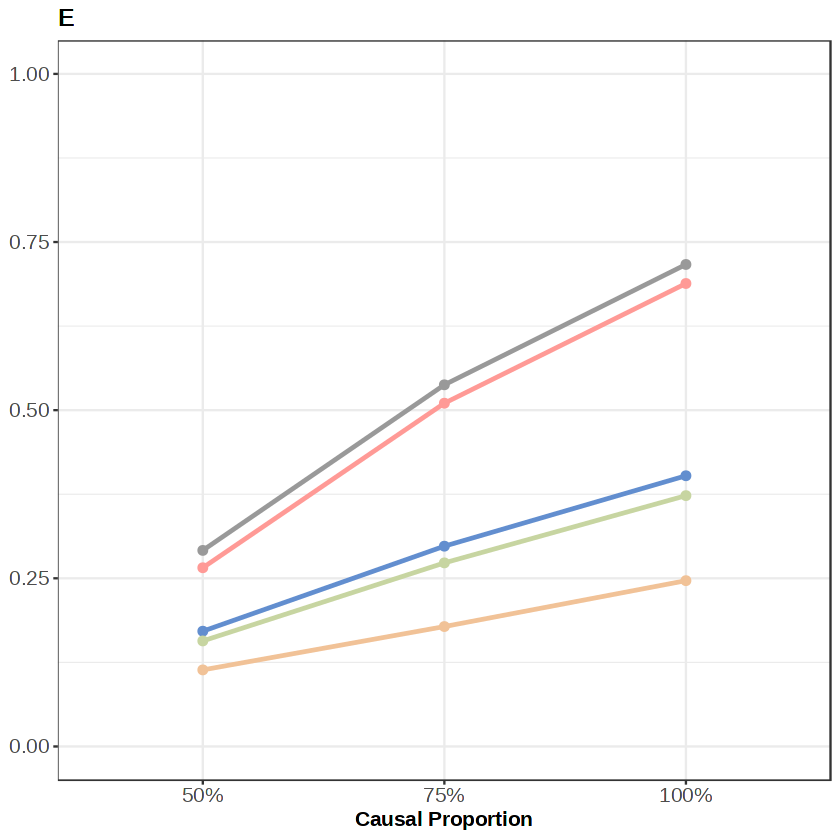

In [37]:
rsq08_maf0005_prev01 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.005",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "E") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
      axis.text.y = element_text(size = text_size),
      axis.title.y = element_blank(),
      strip.text.x = element_text(size = text_size+2, face = "bold"),
      title = element_text(size=12,face="bold"),
      strip.background = element_rect(fill="lightgrey",size=1),
      legend.position = "")
rsq08_maf0005_prev01

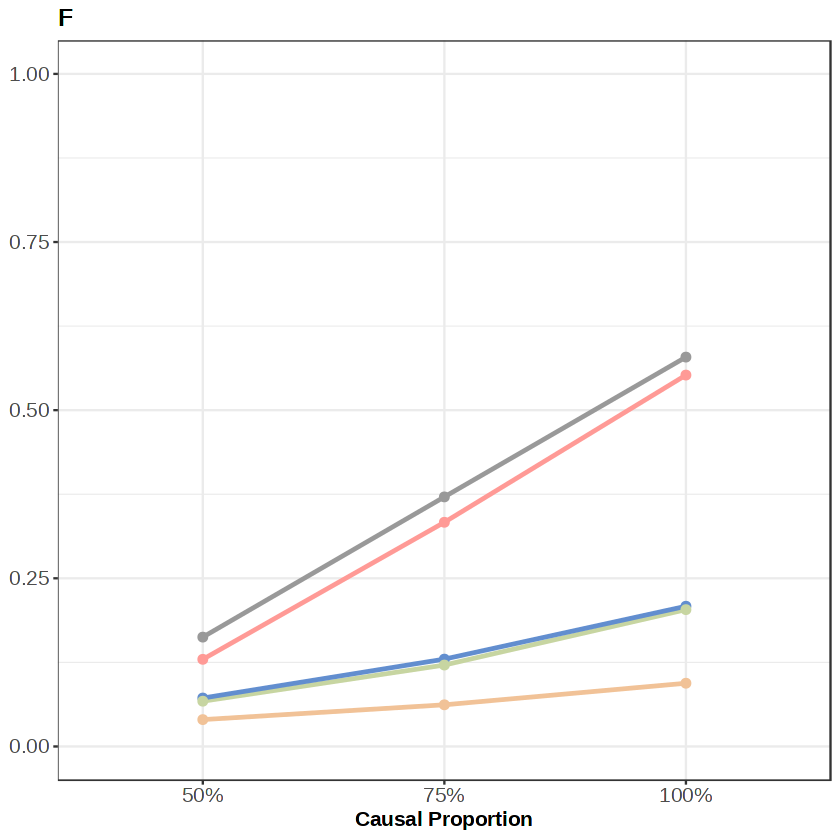

In [38]:
rsq08_maf0001_prev01 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.1, maf == "MAF < 0.001",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "F") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq08_maf0001_prev01

In [40]:
jpeg(file="./power_prev01_maf001_0005.jpg", units="cm", width=21, height=27, res=300)
grid.arrange(rsq03_maf001_prev01, rsq03_maf0005_prev01, rsq03_maf0001_prev01, 
             rsq08_maf001_prev01, rsq08_maf0005_prev01, rsq08_maf0001_prev01, nrow = 2)
dev.off()

png 
  2

In [44]:
rsq03_maf001_prev02 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.01",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "A") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq03_maf0005_prev02 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.005",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "B") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x =element_blank(),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
    
rsq03_maf0001_prev02 <- rsq03_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.001",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "C") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x = element_blank(),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [45]:
rsq08_maf001_prev02 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.01",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "D") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq08_maf0005_prev02 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.005",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "E") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
      axis.text.y = element_text(size = text_size),
      axis.title.y = element_blank(),
      strip.text.x = element_text(size = text_size+2, face = "bold"),
      title = element_text(size=12,face="bold"),
      strip.background = element_rect(fill="lightgrey",size=1),
      legend.position = "")

rsq08_maf0001_prev02 <- rsq08_all_result %>% 
    filter(es == 1.5, prevlence == 0.2, maf == "MAF < 0.001",
           !Dataset %in% c("ES¹", "HRC¹", "TOPMed¹", "HRC + TOPMed¹", "HRC + TOPMed + ES¹")) %>%
    mutate(Dataset = factor(Dataset, levels = c("ES", "HRC", "TOPMed", "HRC + TOPMed", "HRC + TOPMed + ES"))) %>%
    ggplot(aes(x = as.factor(del_prop), y = power, group = Dataset, color = Dataset)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    labs(title = "F") +
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.text.y = element_text(size = text_size),
          axis.title.y = element_blank(),
          strip.text.x = element_text(size = text_size+2, face = "bold"),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [46]:
jpeg(file="./power_prev02_maf001_0005.jpg", units="cm", width=21, height=27, res=300)
grid.arrange(rsq03_maf001_prev02, rsq03_maf0005_prev02, rsq03_maf0001_prev02, 
             rsq08_maf001_prev02, rsq08_maf0005_prev02, rsq08_maf0001_prev02, nrow = 2)
dev.off()

png 
  2

## QQ-plots

In [60]:
rsq03_maf001_exome_pval <- fread("rsq03_maf001_exome_result_type1e.csv")
rsq03_maf001_hrc_pval <- fread("rsq03_maf001_hrc_result_type1e.csv")
rsq03_maf001_topmed_pval <- fread("rsq03_maf001_topmed_result_type1e.csv")
rsq03_maf001_hrc_topmed_pval <- fread("rsq03_maf001_hrc_topmed_result_type1e.csv")
rsq03_maf001_hrc_topmed_exome_pval <- fread("rsq03_maf001_hrc_topmed_exome_result_type1e.csv")

rsq03_maf0005_exome_pval <- fread("rsq03_maf0005_exome_result_type1e.csv")
rsq03_maf0005_hrc_pval <- fread("rsq03_maf0005_hrc_result_type1e.csv")
rsq03_maf0005_topmed_pval <- fread("rsq03_maf0005_topmed_result_type1e.csv")
rsq03_maf0005_hrc_topmed_pval <- fread("rsq03_maf0005_hrc_topmed_result_type1e.csv")
rsq03_maf0005_hrc_topmed_exome_pval <- fread("rsq03_maf0005_hrc_topmed_exome_result_type1e.csv")

rsq03_maf0001_exome_pval <- fread("rsq03_maf0001_exome_result_type1e.csv")
rsq03_maf0001_hrc_pval <- fread("rsq03_maf0001_hrc_result_type1e.csv")
rsq03_maf0001_topmed_pval <- fread("rsq03_maf0001_topmed_result_type1e.csv")
rsq03_maf0001_hrc_topmed_pval <- fread("rsq03_maf0001_hrc_topmed_result_type1e.csv")
rsq03_maf0001_hrc_topmed_exome_pval <- fread("rsq03_maf0001_hrc_topmed_exome_result_type1e.csv")

In [61]:
rsq08_maf001_exome_pval <- fread("rsq08_maf001_exome_result_type1e.csv")
rsq08_maf001_hrc_pval <- fread("rsq08_maf001_hrc_result_type1e.csv")
rsq08_maf001_topmed_pval <- fread("rsq08_maf001_topmed_result_type1e.csv")
rsq08_maf001_hrc_topmed_pval <- fread("rsq08_maf001_hrc_topmed_result_type1e.csv")
rsq08_maf001_hrc_topmed_exome_pval <- fread("rsq08_maf001_hrc_topmed_exome_result_type1e.csv")

rsq08_maf0005_exome_pval <- fread("rsq08_maf0005_exome_result_type1e.csv")
rsq08_maf0005_hrc_pval <- fread("rsq08_maf0005_hrc_result_type1e.csv")
rsq08_maf0005_topmed_pval <- fread("rsq08_maf0005_topmed_result_type1e.csv")
rsq08_maf0005_hrc_topmed_pval <- fread("rsq08_maf0005_hrc_topmed_result_type1e.csv")
rsq08_maf0005_hrc_topmed_exome_pval <- fread("rsq08_maf0005_hrc_topmed_exome_result_type1e.csv")

rsq08_maf0001_exome_pval <- fread("rsq08_maf0001_exome_result_type1e.csv")
rsq08_maf0001_hrc_pval <- fread("rsq08_maf0001_hrc_result_type1e.csv")
rsq08_maf0001_topmed_pval <- fread("rsq08_maf0001_topmed_result_type1e.csv")
rsq08_maf0001_hrc_topmed_pval <- fread("rsq08_maf0001_hrc_topmed_result_type1e.csv")
rsq08_maf0001_hrc_topmed_exome_pval <- fread("rsq08_maf0001_hrc_topmed_exome_result_type1e.csv")

In [70]:
qqplot_generator_rsq03 <- function(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df, prev_threshold, label){
    p1.sorted <- exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p2.sorted <- hrc_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p3.sorted <- topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p4.sorted <- hrc_topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p5.sorted <- hrc_topmed_exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()

    exome_df <- data.frame(exome_x = -log10(ppoints(p1.sorted)), exome_y = -log10(p1.sorted))
    hrc_df <- data.frame(hrc_x = -log10(ppoints(p2.sorted)), hrc_y = -log10(p2.sorted))
    topmed_df <- data.frame(topmed_x = -log10(ppoints(p3.sorted)), topmed_y = -log10(p3.sorted))
    hrc_topmed_df <- data.frame(hrc_topmed_x = -log10(ppoints(p4.sorted)), hrc_topmed_y = -log10(p4.sorted))
    hrc_topmed_exome_df <- data.frame(hrc_topmed_exome_x = -log10(ppoints(p5.sorted)), hrc_topmed_exome_y = -log10(p5.sorted))
    
    if(label == "A"){
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  title = element_text(size=12,face="bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.x = element_blank(),
                  plot.caption = element_text(hjust = 0, face="bold"))
        } else {
            plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  title = element_text(size=12,face="bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  plot.caption = element_text(hjust = 0, face="bold"))
        }
        
    return(plt)
}

In [71]:
qqplot_generator_rsq08 <- function(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df, prev_threshold, label){
    p1.sorted <- exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p2.sorted <- hrc_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p3.sorted <- topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p4.sorted <- hrc_topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p5.sorted <- hrc_topmed_exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()

    exome_df <- data.frame(exome_x = -log10(ppoints(p1.sorted)), exome_y = -log10(p1.sorted))
    hrc_df <- data.frame(hrc_x = -log10(ppoints(p2.sorted)), hrc_y = -log10(p2.sorted))
    topmed_df <- data.frame(topmed_x = -log10(ppoints(p3.sorted)), topmed_y = -log10(p3.sorted))
    hrc_topmed_df <- data.frame(hrc_topmed_x = -log10(ppoints(p4.sorted)), hrc_topmed_y = -log10(p4.sorted))
    hrc_topmed_exome_df <- data.frame(hrc_topmed_exome_x = -log10(ppoints(p5.sorted)), hrc_topmed_exome_y = -log10(p5.sorted))
    # plt_df <- rbind(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df)

    if(label == "D"){
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  title = element_text(size=12,face="bold"),
                  plot.caption = element_text(hjust = 0, face="bold"))
    } else {
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.y = element_blank(),
                  title = element_text(size=12,face="bold"),
                  plot.caption = element_text(hjust = 0, face="bold"))
    }
        
    
    return(plt)
}

In [72]:
qq_rsq03_maf001 <- qqplot_generator_rsq03(rsq03_maf001_exome_pval, 
                                          rsq03_maf001_hrc_pval, 
                                          rsq03_maf001_topmed_pval, 
                                          rsq03_maf001_hrc_topmed_pval, 
                                          rsq03_maf001_hrc_topmed_exome_pval, 
                                          0.2, "A")

qq_rsq03_maf0005 <- qqplot_generator_rsq03(rsq03_maf0005_exome_pval, 
                                           rsq03_maf0005_hrc_pval, 
                                           rsq03_maf0005_topmed_pval, 
                                           rsq03_maf0005_hrc_topmed_pval, 
                                           rsq03_maf0005_hrc_topmed_exome_pval, 
                                           0.2, "B")

qq_rsq03_maf0001 <- qqplot_generator_rsq03(rsq03_maf0001_exome_pval, 
                                           rsq03_maf0001_hrc_pval, 
                                           rsq03_maf0001_topmed_pval, 
                                           rsq03_maf0001_hrc_topmed_pval, 
                                           rsq03_maf0001_hrc_topmed_exome_pval, 
                                           0.2, "C")

In [73]:
qq_rsq08_maf001 <- qqplot_generator_rsq08(rsq08_maf001_exome_pval, 
                                          rsq08_maf001_hrc_pval, 
                                          rsq08_maf001_topmed_pval, 
                                          rsq08_maf001_hrc_topmed_pval, 
                                          rsq08_maf001_hrc_topmed_exome_pval, 
                                          0.2, "D")

qq_rsq08_maf0005 <- qqplot_generator_rsq08(rsq08_maf0005_exome_pval, 
                                           rsq08_maf0005_hrc_pval, 
                                           rsq08_maf0005_topmed_pval, 
                                           rsq08_maf0005_hrc_topmed_pval, 
                                           rsq08_maf0005_hrc_topmed_exome_pval, 
                                           0.2, "E")

qq_rsq08_maf0001 <- qqplot_generator_rsq08(rsq08_maf0001_exome_pval, 
                                           rsq08_maf0001_hrc_pval, 
                                           rsq08_maf0001_topmed_pval, 
                                           rsq08_maf0001_hrc_topmed_pval, 
                                           rsq08_maf0001_hrc_topmed_exome_pval, 
                                           0.2, "F")

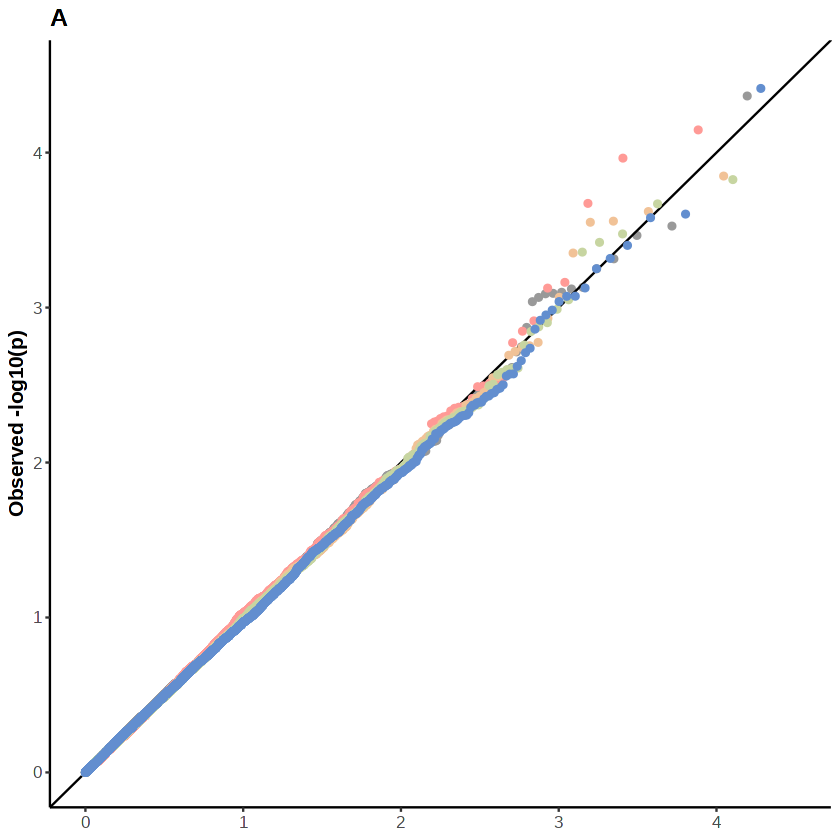

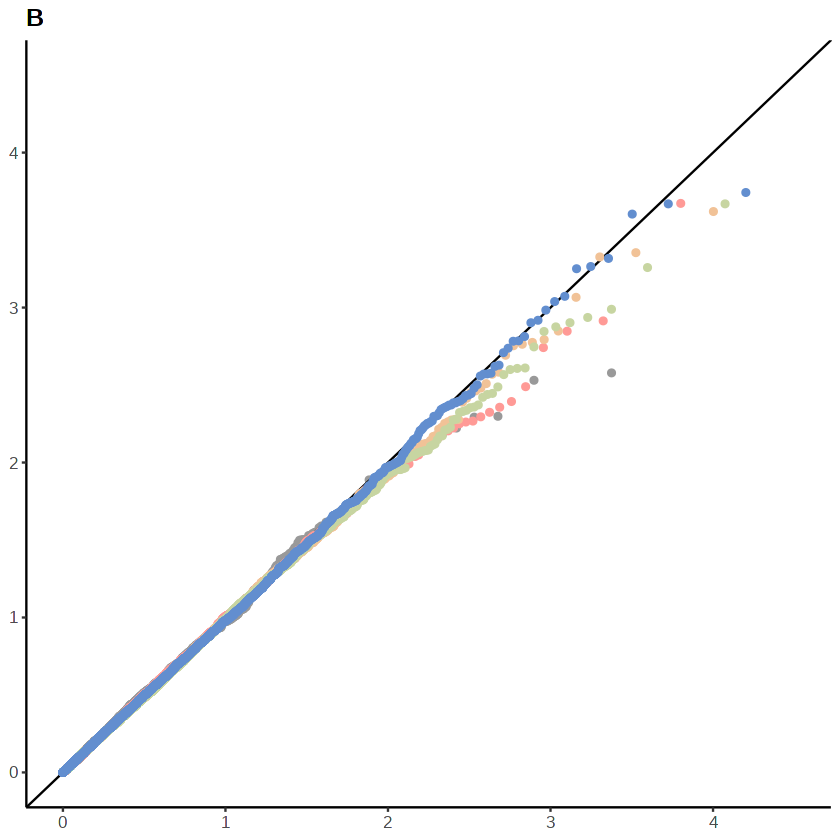

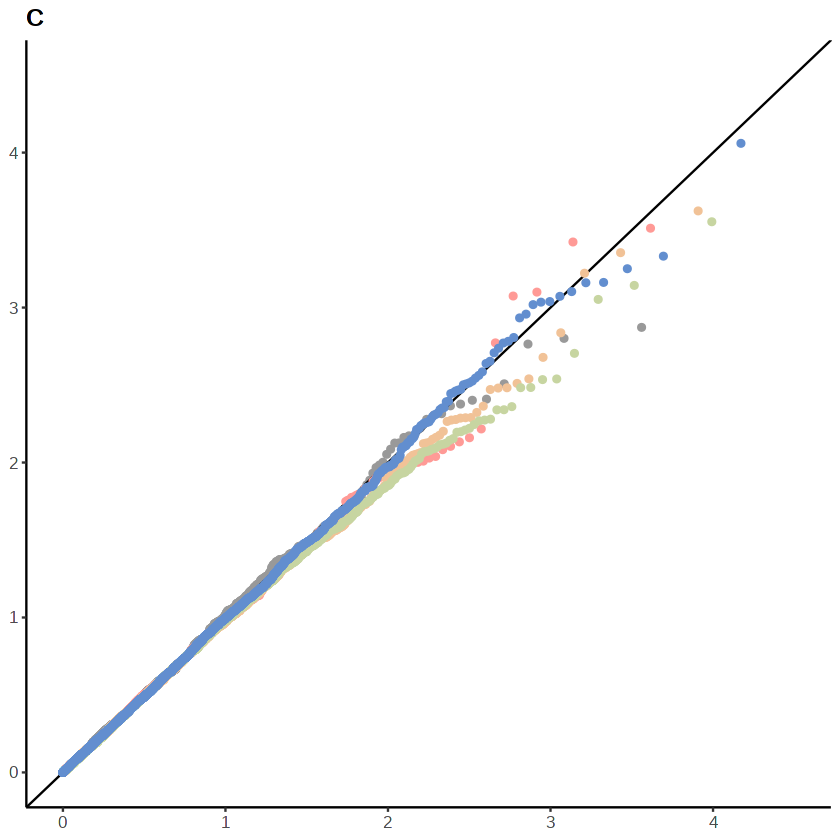

In [74]:
qq_rsq03_maf001
qq_rsq03_maf0005
qq_rsq03_maf0001

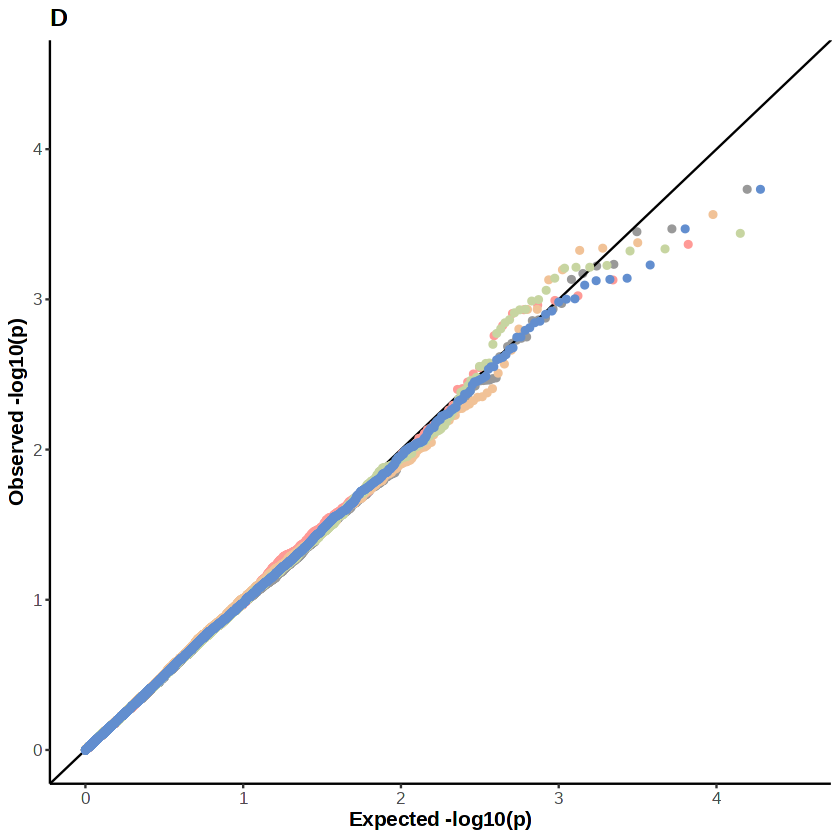

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


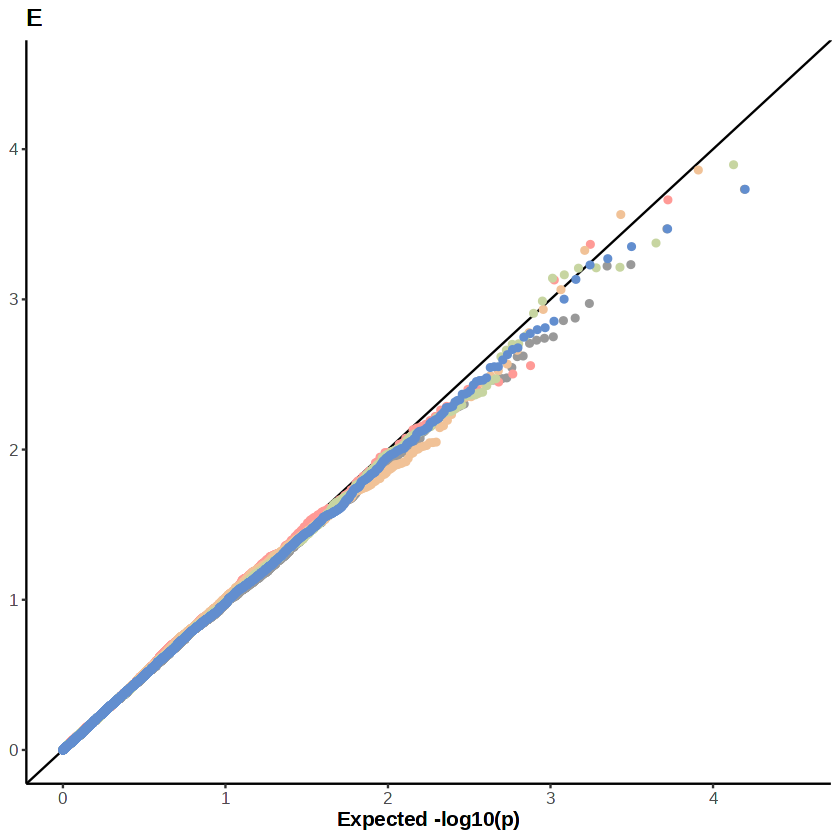

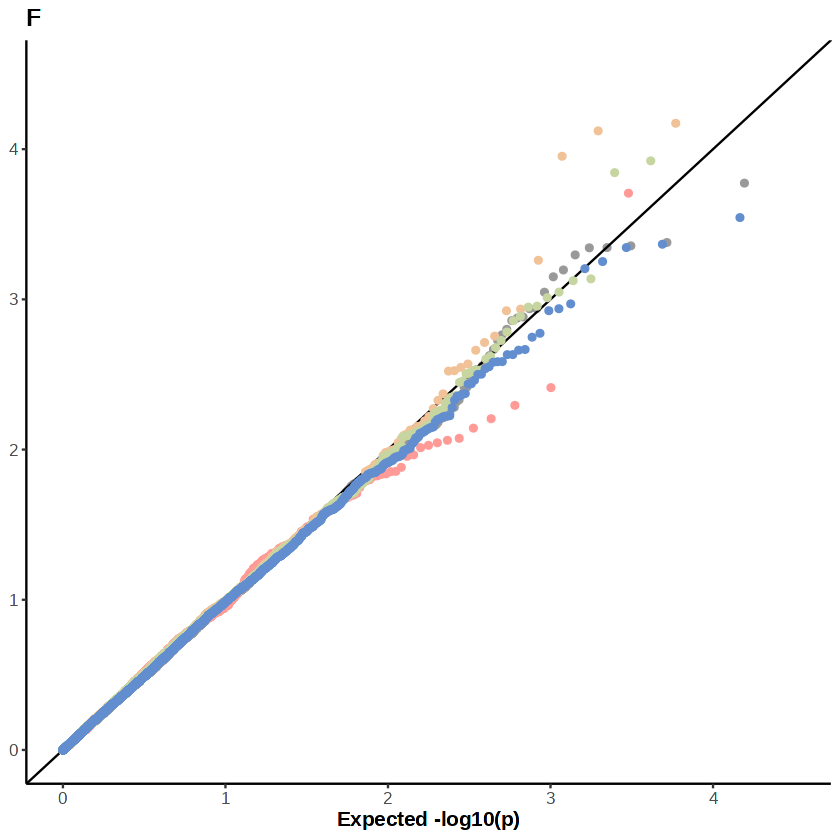

In [75]:
qq_rsq08_maf001
qq_rsq08_maf0005
qq_rsq08_maf0001

In [76]:
jpeg(file="./type1error_maf001_0005.jpg", units="cm", width=27, height=21, res=300)
grid.arrange(qq_rsq03_maf001, qq_rsq03_maf0005, qq_rsq03_maf0001, 
             qq_rsq08_maf001, qq_rsq08_maf0005, qq_rsq08_maf0001, nrow = 2)
dev.off()

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


png 
  2

# Additional Queries

## R2 vs r2